In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.model_selection import cross_val_score, KFold,StratifiedKFold,train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression


from subprocess import check_output
print(check_output(["ls","../data/titanic"]).decode("utf8"))

train_data = pd.read_csv('../data/titanic/train.csv', dtype={'Age': np.float16})

train_data.head()

gender_submission.csv
test.csv
train.csv



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
print('Train columns with null values:\n', train_data.isnull().sum())
print("-" * 10)

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------


In [3]:
data = [train_data]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
train_data['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,relatives,not_alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1


In [5]:
train_data=train_data.drop(['Cabin','PassengerId',"Ticket","Fare"], axis=1)

In [6]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Embarked,relatives,not_alone
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,S,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,C,1,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,S,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,S,1,0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,S,0,1


In [7]:
data = [train_data]
for dataset in data:
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0],inplace=True)
    Embarked = np.zeros(len(dataset))
    Embarked[dataset['Embarked']== 'C'] = 1
    Embarked[dataset['Embarked']== 'Q'] = 2
    Embarked[dataset['Embarked']== 'S'] = 3
    dataset['Embarked'] = Embarked

In [8]:
train_data['Age'].fillna(train_data['Age'].median(), inplace = True)

In [9]:
print('Train columns with null values:\n', train_data.isnull().sum())
print("-" * 10)

Train columns with null values:
 Survived     0
Pclass       0
Name         0
Sex          0
Age          0
SibSp        0
Parch        0
Embarked     0
relatives    0
not_alone    0
dtype: int64
----------


In [10]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Embarked,relatives,not_alone
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,3.0,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,1.0,1,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,3.0,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,3.0,1,0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,3.0,0,1


In [12]:
data = [train_data]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_data = train_data.drop(['Name'], axis=1)

In [13]:
data = [train_data]
for dataset in data:
    sex = np.zeros(len(dataset))
    sex[dataset['Sex']== 'male'] = 1
    sex[dataset['Sex']== 'female'] = 0
    dataset['Sex'] = sex

In [14]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,relatives,not_alone,Title
0,0,3,1.0,22.0,1,0,3.0,1,0,1
1,1,1,0.0,38.0,1,0,1.0,1,0,3
2,1,3,0.0,26.0,0,0,3.0,0,1,2
3,1,1,0.0,35.0,1,0,3.0,1,0,3
4,0,3,1.0,35.0,0,0,3.0,0,1,1


In [15]:
X = train_data.drop("Survived", axis=1)
y= train_data["Survived"]

X_train, X_test, Y_train, Y_test = train_test_split(X, y,test_size = 0.20)

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

In [79]:
"""TEK BİR KARAR AĞACI İLE ÇÖZÜM"""

dtc_scores = []
dtc_scores_test = []
dtc_auc_scores = []

for x in range(1,10):   
    decision_tree = tree.DecisionTreeClassifier(criterion="gini",max_depth=x)
    decision_tree.fit(X_train, Y_train)
    Y_pred=decision_tree.predict(X_test)
    
    acc_dtc = round(decision_tree.score(X_train, Y_train) * 100, 2)
    dtc_auc_score = round(roc_auc_score(Y_test, Y_pred) * 100, 2)
    acc_dtctest = round(decision_tree.score(X_test, Y_test) * 100, 2)
    
    print("Decision Tree Train score for {} depth =".format(x) ,acc_dtc)
    print("Decision Tree Test score for {} depth = ".format(x) ,acc_dtctest)
    print("AUC SCORE for {} depth =".format(x)  ,dtc_auc_score , "\n")
    
    dtc_scores.append(acc_dtc)
    dtc_auc_scores.append(dtc_auc_score)
    dtc_scores_test.append(acc_dtctest)
    

print("Train Scores list:", dtc_scores)
print("Test Scores list:",dtc_scores_test)
print("AUC list:",dtc_auc_scores)

Decision Tree Train score for 1 depth = 77.81
Decision Tree Test score for 1 depth =  79.89
AUC SCORE for 1 depth = 78.84 

Decision Tree Train score for 2 depth = 78.65
Decision Tree Test score for 2 depth =  79.89
AUC SCORE for 2 depth = 71.66 

Decision Tree Train score for 3 depth = 82.44
Decision Tree Test score for 3 depth =  86.03
AUC SCORE for 3 depth = 83.39 

Decision Tree Train score for 4 depth = 83.57
Decision Tree Test score for 4 depth =  84.36
AUC SCORE for 4 depth = 82.15 

Decision Tree Train score for 5 depth = 84.55
Decision Tree Test score for 5 depth =  83.8
AUC SCORE for 5 depth = 81.28 

Decision Tree Train score for 6 depth = 86.94
Decision Tree Test score for 6 depth =  82.12
AUC SCORE for 6 depth = 78.7 

Decision Tree Train score for 7 depth = 87.64
Decision Tree Test score for 7 depth =  81.56
AUC SCORE for 7 depth = 77.84 

Decision Tree Train score for 8 depth = 89.61
Decision Tree Test score for 8 depth =  81.56
AUC SCORE for 8 depth = 79.18 

Decision T

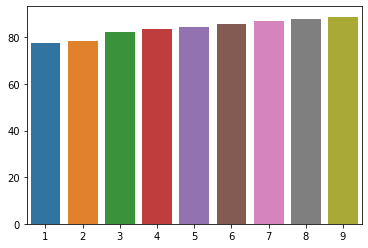

In [73]:
ax = sns.barplot(x= list(range(1,10)) , y= dtc_scores)

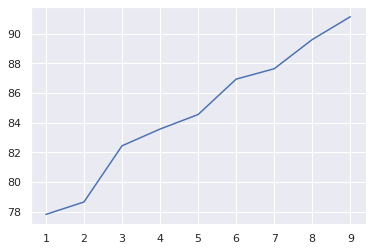

In [83]:
sns.set(style="darkgrid")
sns.lineplot(x= list(range(1,10)) , y= dtc_scores)

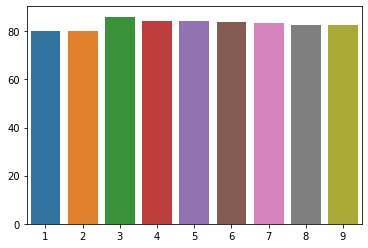

In [74]:
ax = sns.barplot(x= list(range(1,10)) , y= dtc_scores_test)

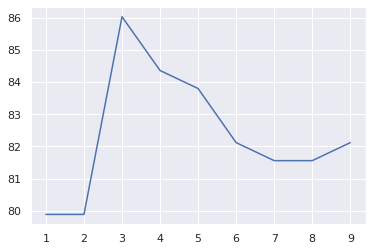

In [84]:
sns.set(style="darkgrid")
sns.lineplot(x= list(range(1,10)) , y= dtc_scores_test)

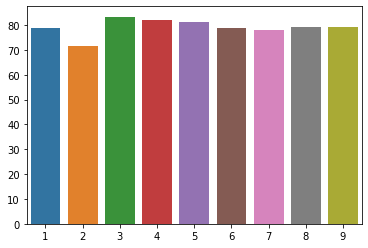

In [80]:
ax = sns.barplot(x= list(range(1,10)) , y= dtc_auc_scores)

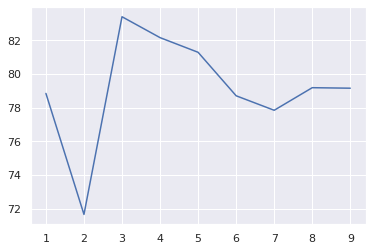

In [85]:
sns.set(style="darkgrid")
sns.lineplot(x= list(range(1,10)) , y= dtc_auc_scores)

In [54]:
"""BAGGING KULLANARAK YAPILAN KARAR AĞACI ÇÖZÜMÜ"""

samples = [5,10,25,50,100,250,500]
scores = []
scores_test = []
auc_scores = []

for x in samples:   
    bg = BaggingClassifier(DecisionTreeClassifier(),max_samples=x, 
                       max_features=1.0, n_estimators=25, 
                       bootstrap = True)
    bg.fit(X_train,Y_train)
    Y_pred = bg.predict(X_test)

    acc_bgdtc = round(bg.score(X_train, Y_train) * 100, 2)
    bg_auc_score = round(roc_auc_score(Y_test, Y_pred) * 100, 2)
    acc_bgdtctest = round(bg.score(X_test, Y_test) * 100, 2)

    print("Bagging Decision Tree Train score for {} samples =".format(x) ,acc_bgdtc)
    print("Bagging Decision Tree Test score for {} samples = ".format(x) ,acc_bgdtctest)
    print("AUC SCORE for {} samples =".format(x)  ,bg_auc_score , "\n")
    scores.append(acc_bgdtc)
    auc_scores.append(bg_auc_score)
    scores_test.append(acc_bgdtctest)
    

print("Train Scores list:", scores)
print("Test Scores list:",scores_test)
print("AUC list:",auc_scores)

Bagging Decision Tree Train score for 5 samples = 73.03
Bagging Decision Tree Test score for 5 samples =  76.54
AUC SCORE for 5 samples = 68.28 

Bagging Decision Tree Train score for 10 samples = 76.54
Bagging Decision Tree Test score for 10 samples =  80.45
AUC SCORE for 10 samples = 74.32 

Bagging Decision Tree Train score for 25 samples = 81.46
Bagging Decision Tree Test score for 25 samples =  82.12
AUC SCORE for 25 samples = 80.94 

Bagging Decision Tree Train score for 50 samples = 83.15
Bagging Decision Tree Test score for 50 samples =  86.03
AUC SCORE for 50 samples = 82.49 

Bagging Decision Tree Train score for 100 samples = 84.69
Bagging Decision Tree Test score for 100 samples =  85.47
AUC SCORE for 100 samples = 82.52 

Bagging Decision Tree Train score for 250 samples = 89.04
Bagging Decision Tree Test score for 250 samples =  82.68
AUC SCORE for 250 samples = 80.01 

Bagging Decision Tree Train score for 500 samples = 92.84
Bagging Decision Tree Test score for 500 samp

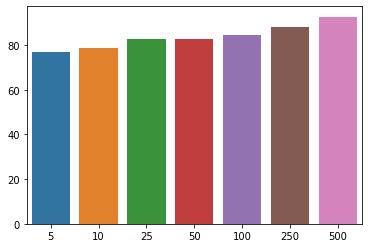

In [42]:
ax = sns.barplot(x= samples , y= scores)

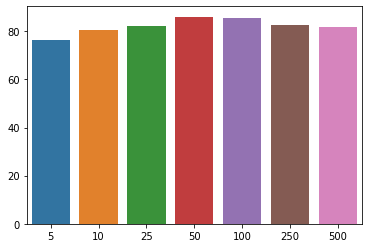

In [55]:
ax = sns.barplot(x= samples , y= scores_test)

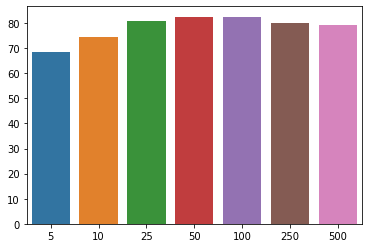

In [56]:
ax = sns.barplot(x= samples , y= auc_scores)

In [112]:
"""RANDOM FOREST ÇÖZÜMÜ"""
estimators = [5,10,25,30,40,50]
rfc_scores = []
rfc_scores_test = []
rfc_auc_scores = []

for x in estimators:   
    rf = RandomForestClassifier(criterion='gini',n_estimators=x,bootstrap= False,
                                max_depth=3,max_features='auto')
    rf.fit(X_train,Y_train)
    
    Y_pred = rf.predict(X_test)

    acc_rf = round(rf.score(X_train, Y_train) * 100, 2)
    rf_auc_score = round(roc_auc_score(Y_test, Y_pred) * 100, 2)
    acc_rftest = round(rf.score(X_test, Y_test) * 100, 2)

    print("Random Forest Train score for {} estimators =".format(x) ,acc_rf)
    print("Random Forest Test score for {} estimators = ".format(x) ,acc_rftest)
    print("AUC SCORE for {} estimators =".format(x)  ,rf_auc_score , "\n")
    rfc_scores.append(acc_rf)
    rfc_auc_scores.append(rf_auc_score)
    rfc_scores_test.append(acc_rftest)
    
print("Train Scores list:", rfc_scores)
print("Test Scores list:",rfc_scores_test)
print("AUC list:",rfc_auc_scores)

Random Forest Train score for 5 estimators = 80.48
Random Forest Test score for 5 estimators =  82.12
AUC SCORE for 5 estimators = 78.7 

Random Forest Train score for 10 estimators = 81.74
Random Forest Test score for 10 estimators =  85.47
AUC SCORE for 10 estimators = 82.52 

Random Forest Train score for 25 estimators = 82.72
Random Forest Test score for 25 estimators =  84.92
AUC SCORE for 25 estimators = 82.56 

Random Forest Train score for 30 estimators = 82.02
Random Forest Test score for 30 estimators =  83.8
AUC SCORE for 30 estimators = 81.73 

Random Forest Train score for 40 estimators = 82.16
Random Forest Test score for 40 estimators =  84.36
AUC SCORE for 40 estimators = 82.15 

Random Forest Train score for 50 estimators = 82.44
Random Forest Test score for 50 estimators =  84.36
AUC SCORE for 50 estimators = 81.7 

Train Scores list: [80.48, 81.74, 82.72, 82.02, 82.16, 82.44]
Test Scores list: [82.12, 85.47, 84.92, 83.8, 84.36, 84.36]
AUC list: [78.7, 82.52, 82.56, 8

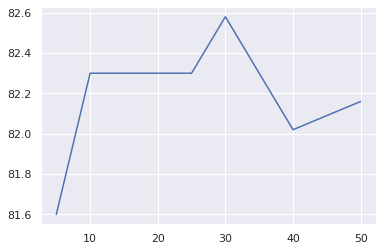

In [109]:
sns.set(style="darkgrid")
sns.lineplot(x= estimators , y= rfc_scores)

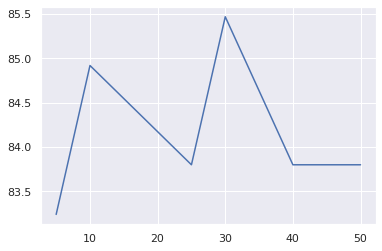

In [110]:
ax = sns.lineplot(x= estimators , y= rfc_scores_test)

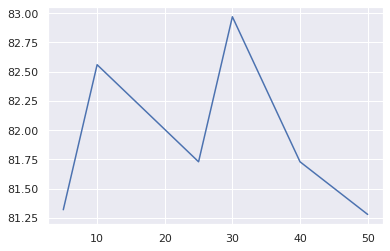

In [111]:
ax = sns.lineplot(x= estimators , y= rfc_auc_scores)

In [137]:
"""ADABOOST"""
estimators = [5,10,25,30,40,50,100,250,500,1000]
adb_rfc_scores = []
adb_rfc_scores_test = []
adb_rfc_auc_scores = []
for x in estimators:
    ad=AdaBoostClassifier(RandomForestClassifier(), n_estimators=x)
    ad.fit(X_train,Y_train)
    Y_pred = ad.predict(X_test)

    acc_adb_rfc = round(ad.score(X_train, Y_train) * 100, 2)
    adb_rfc_auc_score = round(roc_auc_score(Y_test, Y_pred) * 100, 2)
    acc_adb_rfctest = round(ad.score(X_test, Y_test) * 100, 2)

    print("ADABOOST Random Forest Train score for {} estimators =".format(x) ,acc_adb_rfc)
    print("ADABOOST Random Forest Test score for {} estimators = ".format(x) ,acc_adb_rfctest)
    print("AUC SCORE for {} estimators =".format(x)  ,adb_rfc_auc_score , "\n")
    adb_rfc_scores.append(acc_adb_rfc)
    adb_rfc_auc_scores.append(adb_rfc_auc_score)
    adb_rfc_scores_test.append(acc_adb_rfctest)
    
print("Train Scores list:", adb_rfc_scores)
print("Test Scores list:",adb_rfc_scores_test)
print("AUC list:",adb_rfc_auc_scores)


ADABOOST Random Forest Train score for 5 estimators = 93.96
ADABOOST Random Forest Test score for 5 estimators =  83.24
AUC SCORE for 5 estimators = 80.87 

ADABOOST Random Forest Train score for 10 estimators = 93.96
ADABOOST Random Forest Test score for 10 estimators =  82.68
AUC SCORE for 10 estimators = 80.46 

ADABOOST Random Forest Train score for 25 estimators = 93.96
ADABOOST Random Forest Test score for 25 estimators =  82.68
AUC SCORE for 25 estimators = 80.01 

ADABOOST Random Forest Train score for 30 estimators = 93.96
ADABOOST Random Forest Test score for 30 estimators =  83.8
AUC SCORE for 30 estimators = 81.28 

ADABOOST Random Forest Train score for 40 estimators = 93.96
ADABOOST Random Forest Test score for 40 estimators =  83.8
AUC SCORE for 40 estimators = 81.28 

ADABOOST Random Forest Train score for 50 estimators = 93.96
ADABOOST Random Forest Test score for 50 estimators =  83.24
AUC SCORE for 50 estimators = 80.87 

ADABOOST Random Forest Train score for 100 es

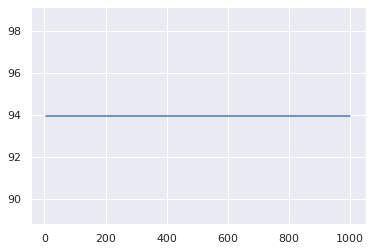

In [138]:
sns.lineplot(x= estimators , y= adb_rfc_scores)

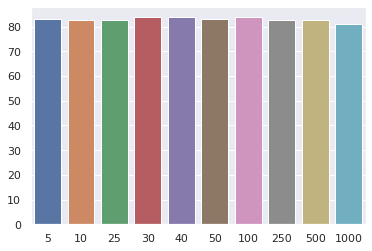

In [140]:
sns.barplot(x= estimators , y= adb_rfc_scores_test)

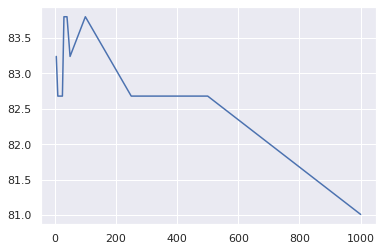

In [139]:
sns.lineplot(x= estimators , y= adb_rfc_scores_test)

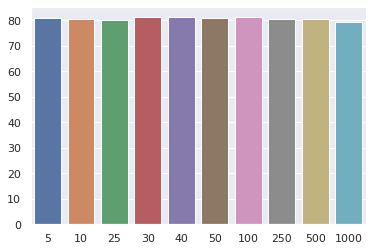

In [141]:
sns.barplot(x= estimators , y= adb_rfc_auc_scores)

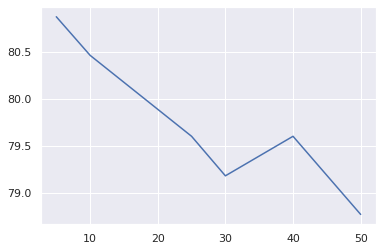

In [135]:
sns.lineplot(x= estimators , y= adb_rfc_auc_scores)

In [156]:
"""GENEL KARŞILAŞTIRMALAR"""

classifiers=["Log Reg","KNN","NB","SVM","DTree","RForest","BGDT","ADBRF"]
results=[79.866,79.357,81.917,80.447,83.39,82.56,82.52,83.8]

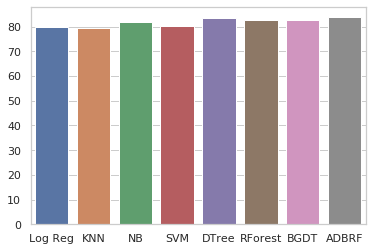

In [160]:
sns.set(style="whitegrid")
ax=sns.barplot(x= classifiers , y= results)

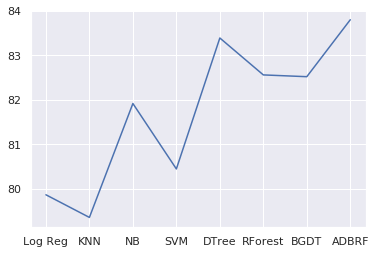

In [168]:
sns.set(style="darkgrid")
ax= sns.lineplot(x= classifiers , y= results,sort=False)